In [1]:
%matplotlib inline
import sys
import json
import pandas
import random
from collections import defaultdict

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('/home/sungmin/Documents/projects_22/taper_graphs/smstyle-formal.mplstyle')

In [2]:
with open('../data/etc/invalid_bug_reports.txt') as f:
    invalid_bugs = [e.strip().replace('-', '_') for e in f.readlines()]

In [3]:
# helper functions
def evaluate(raw_result, only_crash=False):
    rows = []
    
    for bug_id, test_exec_results in raw_result.items():
        if bug_id in invalid_bugs:
            continue
        if only_crash and bug_id not in jcrashpack_bugs:
            continue
            
        for i, (fname, res) in enumerate(test_exec_results.items()):
            javalang_parse_error = False
            is_compile_error = False
            is_runtime_error = False
            buggy_version_failing = False
            fixed_version_failing = False
            success = False

            if isinstance(res, str):
                javalang_parse_error = True 
            elif res['buggy']['compile_error'] or res['fixed']['compile_error']:
                is_compile_error = True
            elif res['buggy']['runtime_error'] or res['fixed']['runtime_error']:
                is_runtime_error = True
            else:
                if res['buggy']['autogen_failed']:
                    buggy_version_failing = True
                if res['fixed']['autogen_failed']:
                    fixed_version_failing = True
                if buggy_version_failing and (not fixed_version_failing):
                    success = True
            
            rows.append({
                'project': bug_id.split('_')[0],
                'bug_id': bug_id,
                'test_no': i+1,
                'javalang_parse_error': javalang_parse_error,
                'is_compile_error': is_compile_error,
                'is_runtime_error': is_runtime_error,
                'buggy_version_failing': buggy_version_failing,
                'fixed_version_failing': fixed_version_failing,
                'fname': fname,
                'success': success,
            })
    
    return pandas.DataFrame(rows)

def get_file_results(fname, only_crash=False):
    with open(fname) as f:
        reproduction_df = evaluate(json.load(f), only_crash)
    
    reproduction_df['project'] = reproduction_df.bug_id.apply(lambda x: x.split('_')[0])
    
    return reproduction_df

def key_at_n(key, eval_df, count=50):
    succ_at_try = defaultdict(list)
    for idx in range(count):
        succ_at_try[idx] = set(eval_df[(eval_df.test_no == (idx+1)) & 
                                       (eval_df[key] > 0)]['bug_id'])

    x, ys = [], []
    org_list = list(range(count))
    x = org_list[:]
    for sim_idx in range(1000):
        random.shuffle(org_list)
        y = []
        succ_set = set()
        for idx in org_list:
            succ_set |= set(succ_at_try[idx])
            y.append(len(succ_set))
        ys.append(y)
    return np.array(ys)

In [4]:
codex_n50_results = get_file_results('../data/exec_results/codex_n50_2example_d4j.json')
chatgpt_recent_n50_results = get_file_results('../data/exec_results/gpt-3.5-turbo_2example_d4j.json')
chatgpt_0301_results = get_file_results('../data/exec_results/gpt-3.5-turbo-0301_2example_d4j.json')
chatgpt_0613_results = get_file_results('../data/exec_results/gpt-3.5-turbo-0613_2example_d4j.json')

incoder_results = get_file_results('../data/exec_results/Incoder-6B_2example_d4j.json')
codegen2_results = get_file_results('../data/exec_results/codegen2-16B_2example_d4j.json')
starcoderbase_results = get_file_results('../data/exec_results/starcoderbase_2example_d4j.json')
starcoderplus_results = get_file_results('../data/exec_results/starcoderplus_2example_d4j.json')
starcoder_n50_results = get_file_results('../data/exec_results/starcoder_n50_2example_d4j.json')
bloom_results = get_file_results('../data/exec_results/bloom_2example_d4j.json')
bloomz_results = get_file_results('../data/exec_results/bloomz_2example_d4j.json')

,performance
model,
Bloom-176B,66.0
BloomZ-176B,51.0
ChatGPT-0301,164.0
ChatGPT-0613,72.0
ChatGPT-recent,65.0
CodeGen2-16B,76.0
Incoder-6B,44.0
StarCoder-15B,120.0
StarCoderBase-15B,121.0


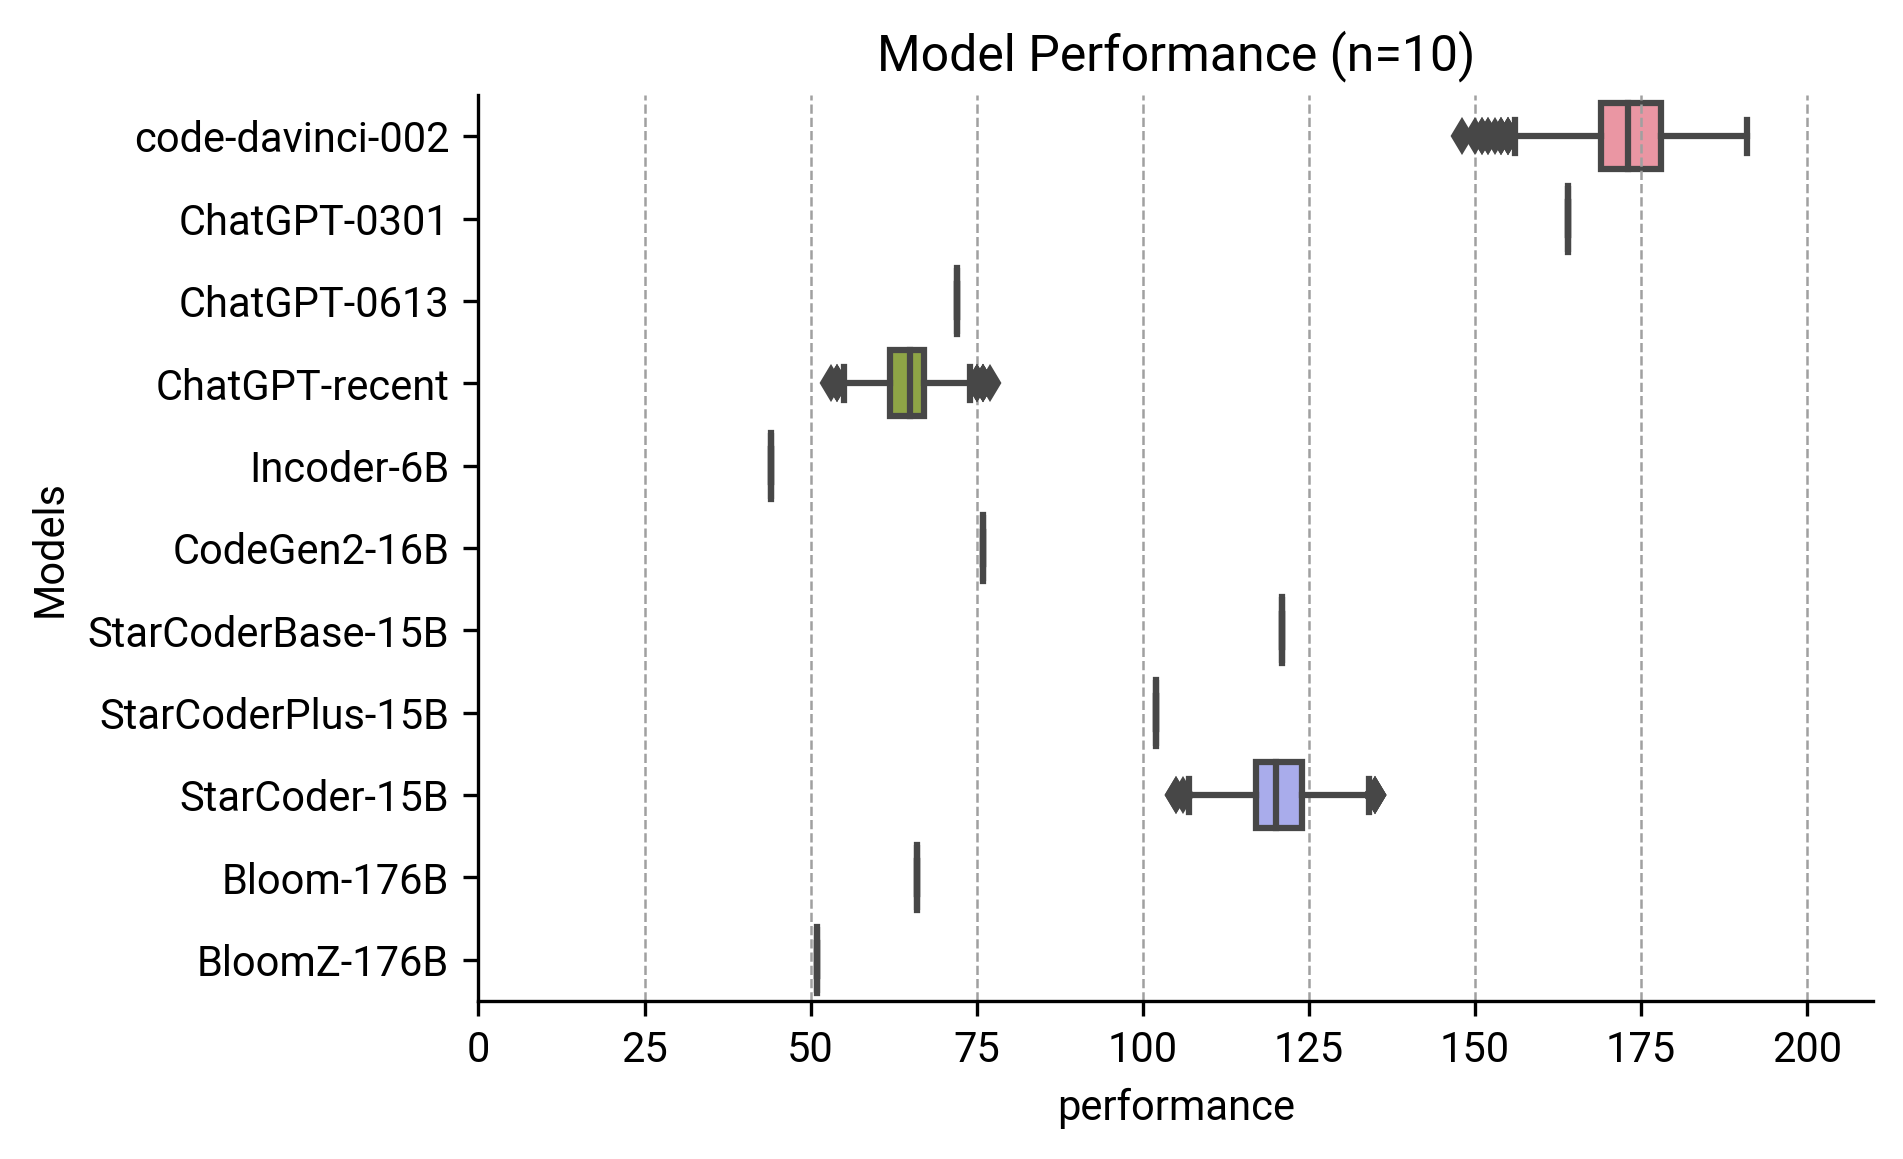

In [5]:
result_dfs = [codex_n50_results, chatgpt_0301_results, chatgpt_0613_results, chatgpt_recent_n50_results,
              incoder_results, codegen2_results, 
              starcoderbase_results, starcoderplus_results, starcoder_n50_results,
              bloom_results, bloomz_results]
count_used = [50, 10, 10, 50, 10, 10, 10, 10, 50, 10, 10]
model_name = ['code-davinci-002', 'ChatGPT-0301', 'ChatGPT-0613', 'ChatGPT-recent', 
              'Incoder-6B', 'CodeGen2-16B', 
              'StarCoderBase-15B', 'StarCoderPlus-15B', 'StarCoder-15B',
              'Bloom-176B', 'BloomZ-176B']
INSPECTING_N = 10
dist_list = []
for r_idx, result_df in enumerate(result_dfs):
    dist_results = key_at_n('success', result_df, count=count_used[r_idx])[:, INSPECTING_N-1]
    for r in dist_results:
        dist_list.append({
            'model': model_name[r_idx],
            'performance': r
        })
dist_df = pandas.DataFrame(dist_list)
sns.boxplot(data=dist_df, x='performance', y='model')
plt.title(f'Model Performance (n={INSPECTING_N})')
plt.ylabel('Models')
plt.xlim(0, 210)
plt.savefig('./figures/model_performance_boxplot.pdf', bbox_inches='tight')
dist_df.groupby('model').median()

Text(0, 0.5, 'Reproduced Bugs')

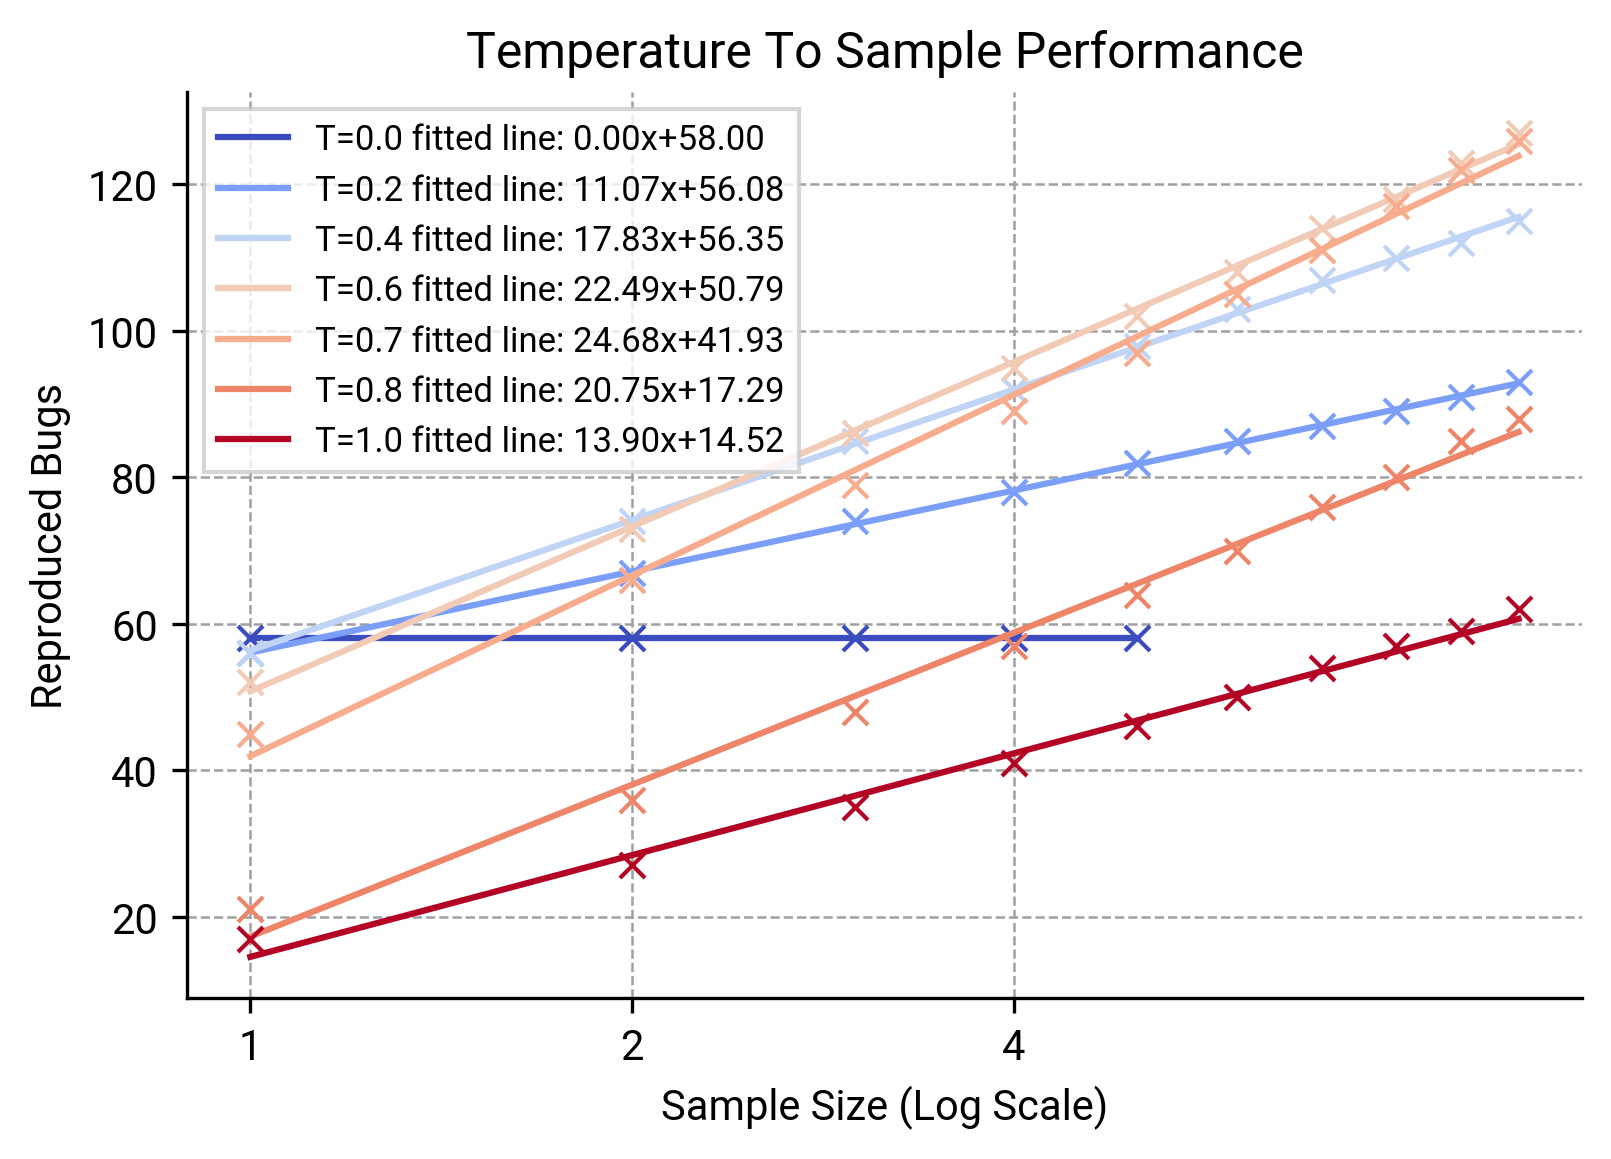

In [6]:
starcoder_temp_results = [
    get_file_results('../data/exec_results/starcoder_T0_2example_d4j.json'),
    get_file_results('../data/exec_results/starcoder_T02_2example_d4j.json'),
    get_file_results('../data/exec_results/starcoder_T04_2example_d4j.json'),
    get_file_results('../data/exec_results/starcoder_T06_2example_d4j.json'),
    get_file_results('../data/exec_results/starcoder_n50_2example_d4j.json'),
    get_file_results('../data/exec_results/starcoder_T08_2example_d4j.json'),
    get_file_results('../data/exec_results/starcoder_T10_2example_d4j.json'),
]
starcoder_temp_labels = [0.0, 0.2, 0.4, 0.6, 0.7, 0.8, 1.0]
total_ns = [5, 10, 10, 10, 50, 10, 10]

for result, temp, total_n in zip(starcoder_temp_results, starcoder_temp_labels, total_ns):
    comp_samples = min(10, total_n)
    plot_x = np.arange(comp_samples)+1
    dist_results = key_at_n('success', result, count=comp_samples)[:, :comp_samples]
    res = scipy.stats.linregress(np.log2(plot_x), np.median(dist_results, axis=0))
    temp_color = mpl.cm.get_cmap('coolwarm')(temp)
    plt.plot(np.log2(plot_x), np.median(dist_results, axis=0), 'x', color=temp_color, )
    plt.plot(np.log2(plot_x), res.intercept + res.slope*np.log2(plot_x), color=temp_color, label=f'T={temp} fitted line: {res.slope:.2f}x+{res.intercept:.2f}')
plt.legend()

plt.title('Temperature To Sample Performance')
plt.xticks([0, 1, 2], [2**e for e in range(3)])
plt.xlabel('Sample Size (Log Scale)')
plt.ylabel('Reproduced Bugs')

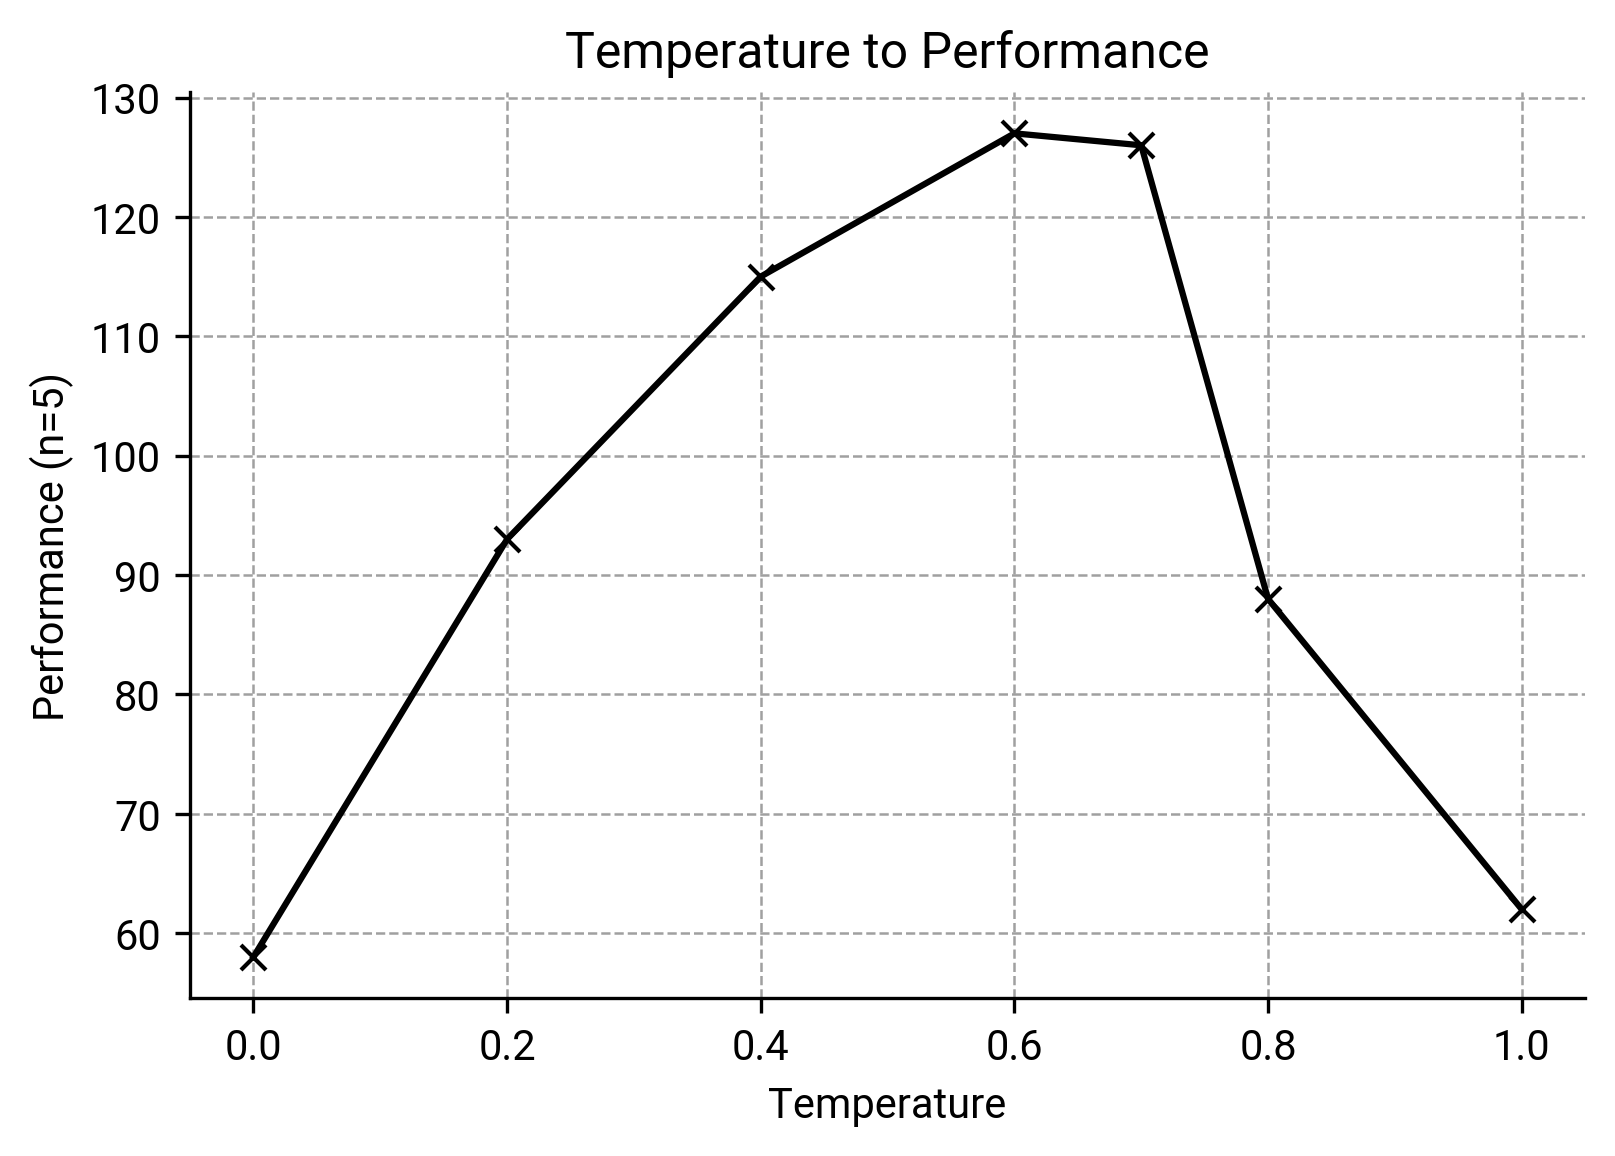

In [7]:
temp_x = []
result_y = []
for result, temp, total_n in zip(starcoder_temp_results, starcoder_temp_labels, total_ns):
    comp_samples = min(10, total_n)
    dist_results = key_at_n('success', result, count=comp_samples)[:, comp_samples-1]
    temp_x.append(temp)
    result_y.append(np.median(dist_results))
plt.plot(temp_x, result_y, 'x-', color='black')
plt.title('Temperature to Performance')
plt.xlabel('Temperature')
plt.ylabel('Performance (n=5)')
plt.savefig('./figures/temp2perf_starcoder.pdf', bbox_inches='tight')

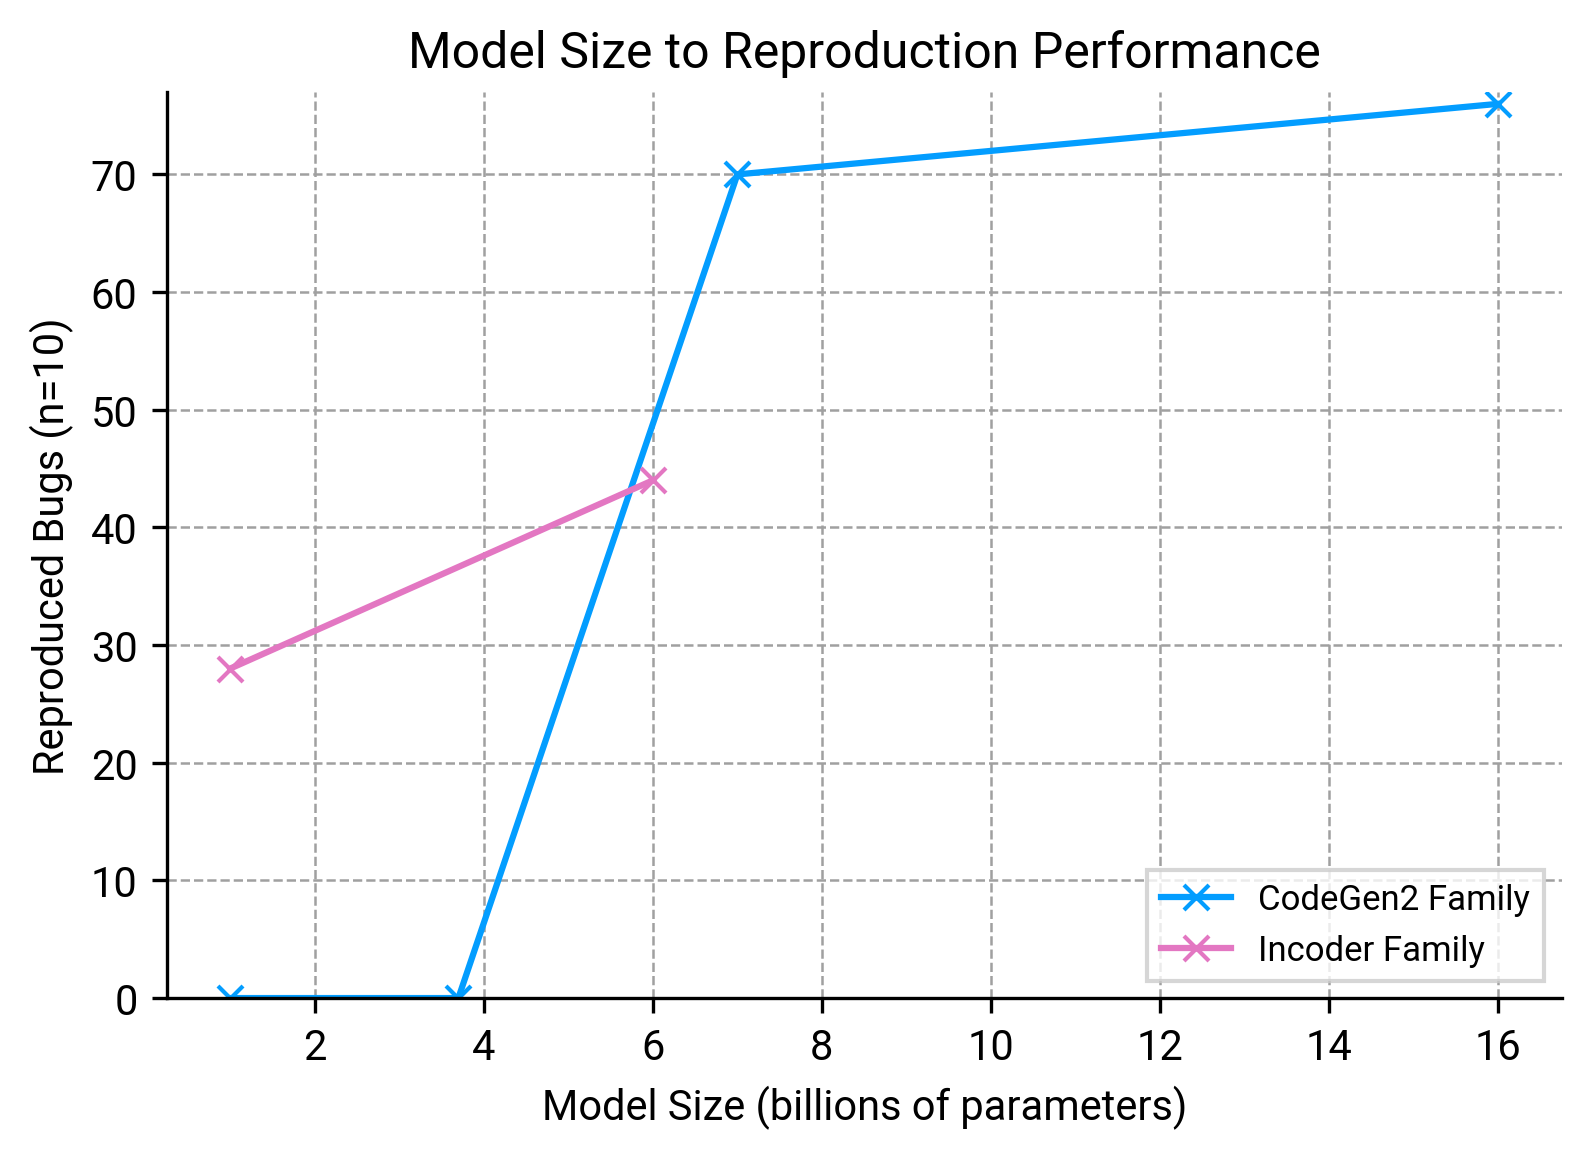

In [8]:
codegen2_size_results = [
    get_file_results('../data/exec_results/codegen2-1B_2example_d4j.json'),
    get_file_results('../data/exec_results/codegen2-3_7B_2example_d4j.json'),
    get_file_results('../data/exec_results/codegen2-7B_2example_d4j.json'),
    get_file_results('../data/exec_results/codegen2-16B_2example_d4j.json'),
]
codegen2_size_labels = [1.0, 3.7, 7.0, 16.0]
total_ns = [10, 10, 10, 10]

size_x = []
result_y = []
for result, size, total_n in zip(codegen2_size_results, codegen2_size_labels, total_ns):
    dist_results = key_at_n('success', result, count=total_n)[:, -1]
    size_x.append(size)
    result_y.append(np.median(dist_results))

plt.plot(size_x, result_y, 'x-', label='CodeGen2 Family')

incoder_size_results = [
    get_file_results('../data/exec_results/Incoder-1B_2example_d4j.json'),
    get_file_results('../data/exec_results/Incoder-6B_2example_d4j.json'),
]
incoder_size_labels = [1.0, 6.0]
total_ns = [10, 10]

size_x = []
result_y = []
for result, size, total_n in zip(incoder_size_results, incoder_size_labels, total_ns):
    dist_results = key_at_n('success', result, count=total_n)[:, -1]
    size_x.append(size)
    result_y.append(np.median(dist_results))
plt.plot(size_x, result_y, 'x-', label='Incoder Family')

plt.ylim(0, 77)
plt.legend(loc='lower right')
plt.xlabel('Model Size (billions of parameters)')
plt.ylabel('Reproduced Bugs (n=10)')
plt.title('Model Size to Reproduction Performance')
plt.savefig('./figures/size_to_performance.pdf', bbox_inches='tight')